# Testing differents losses on Inria Dataset 

**Objectif:** le but de ce notebook est d'entraîner le modèle UNet et d'expliquer et tester les différentes loss sur le jeu de données d'Inria. 

### Root Variables 

Les root variables sont les variables contenant les chemins vers le jeu de donnée Inria. 

* **train_dir** contient les images aériennes de bâtiments pour l'entraînement.
* **gt_dir** contient les masques des bâtiments pour l'entraînement. 
* **test_dir** contient les images aériennes de bâtiments pour l'inférence. 

In [1]:
import os 

In [2]:
root = '/home/ign.fr/ttea/Code_IGN/AerialImageDataset'
train_dir = os.path.join(root,'train/images')
gt_dir = os.path.join(root,'train/gt')
test_dir = os.path.join(root,'test/images')

In [3]:
import sys 

In [4]:
sys.path.insert(0, '/home/ign.fr/ttea/stage_segmentation_2021/Code')

In [5]:
from dataloader.dataloader import InriaDataset
from model.model import UNet
from train import train, eval, train_full

### Import Libraries 

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import json

import argparse
import pandas as pd 

import torch
import torch.nn.functional as F
import torch.nn as nn

In [7]:
var= pd.read_json('variables.json')

## U-Net Model

Voici l'architecture du modèle UNet qu'on va utiliser avec la loss Crossentropy pour entraîner notre modèle.

![title](../img/Unet.png)

## Different Loss

### Binary Crossentropy Loss 

![title](../img/BCE_formula.png)

Nous sommes dans le cas d'une classification binaire. 
 
* **${y_i}$ :** vérité terrain 
* **$p({y_i})$ :** prédiction

**2 Cas :** 
* Si $y = 0$, le premier terme sera égale à 0, on calculera seulement $(1-y) * log({1 - \hat{y}})$ , comme $(1-y) = 1$ on aura juste $log({1 - \hat{y}})$.

* Si $y = 1$, le second terme sera égale à 0 et on calculera le premier terme. 

Binary Crossentropy Loss prend en entrée 2 arguments : 

La prédiction et la target doivent être de la même taille. 
    
- Prédiction, Float Tensor de taille (Nombre_batch, 1, Width, Height)

- Target, Float Tensor de taille (Nombre_batch, 1, Width, Height)

On a ici 1, car on est dans le cas d'une seule classe. 

Retourne : un Scalaire, si l'opération de réduction n'est pas précisé, cela va retourner la même taille que la target.  



### Crossentropy Loss 

https://medium.com/data-science-bootcamp/understand-cross-entropy-loss-in-minutes-9fb263caee9a

![title](../img/crossentropy.png)

On cherche à mesurer la similarité entre la prédiction & la vérité terrain. 

La crossentropy va nous permettre de mesurer à quel point la fonction softmax est performante. 

**Etapes :**

1) Softmax prend le log en première entrée (car des valeurs très négatives)

2) on multiplie par la vérité terrain

3) On le fait pour chaque entrée 

4) On somme toutes les loss 

5) On multiplie par -1 pour avoir la loss positive 

**${y_i}$ :** vérité terrain 

**$\hat{y}$ :** prédiction

**$\frac{1}{N}$ :** on cherche à calculer la moyenne

**Crossentropy Loss prend en entrée 2 arguments :** 
    
- **Prédiction**, Long Tensor de taille (Nombre_batch, Nombre de classe, Width, Height)

- **Target**, Long Tensor de taille (Nombre_batch, Nombre de classe, Width, Height)

**Retourne :** un Scalaire, si l'opération de réduction n'est pas précisé, cela va retourner la même taille que la target.  

### Limitation de la Crossentropy 



Lors du calcul de la crossentropy, on calcule la loss en moyennant la loss de chaque pixel et chaque loss de des pixels est calculée discrètement, sans même savoir si les pixels adjacents sont des frontières ou non. Ainsi, les bords des pixels prédits ne sont pas très précis et ce n'est donc pas assez précis pour une prédiction d'image. 

### Dice Loss 

![title](../img/dice_coefficient.png)

On retrouve l'équation du coefficient Dice, dans lequel pi & gi représentes les pairs correspondants à la valeur des pixels de prédictions et de la vérité terrain. Lors de la détection des frontières, les valeurs de pi & gi sont 0 ou 1 (1 si le pixel est une frontière, 0 sinon). 

Le numérateur représente la somme des pixels frontaliers correctement prédits car la somme n'augmente que lorsque pi et gi correspondent (tous deux de valeur 1).

Le dénominateur représente la somme des pixels frontaliers totaux de la prédiction et de la vérité terrain.

![title](../img/dice_coefficient_set.png)

Une autre façon de le voir, c'est de considérer le coefficient Dice comme l'intersection entre 2 ensembles. Par exemple, Si les ensembles A & B s'intersectent parfaitement, le coefficient Dice sera égale à 1 (valeur maximale). 

Sinon, lorsque la valeur du coefficient de Dice décroit à 0, cela signifie que l'intersection entre l'ensemble A & B est nulle. 

La valeur du coefficient de Dice est comprise entre 0 & 1. Plus elle est grande, mieux elle est. Ainsi, nous calculons l'inverse, 1 - coefficient de Dice afin de maximiser l'intersection entre les 2 ensembles. Donc de minimiser la loss. 

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b



### Implementation Dice Loss

Code source: https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py

In [8]:
def BinaryDiceLoss(predict, target):
    """
    predict : prediction -> Float Tensor (nb_batch,width, height)
    target : ground truth -> Float Tensor (nb_batch, width, height)
    
    Returns: Binary Dice loss -> Float Tensor 
    """
    
    smooth = 1
    
    predict = predict.contiguous().view(predict.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)

    num = torch.sum(torch.mul(predict, target), dim=1) + smooth
    den = torch.sum(predict.pow(2) + target.pow(2), dim=1) + smooth

    dice = 2*num / den
    
    loss = 1 - dice
    
    loss = loss.mean() # reduction by mean 
    return loss 

### Dice Loss combine with Crossentropy

La dice loss ayant une faible convergence lorsqu'elle est utilisée seule, nous allons donc combiner la dice loss et la crossentropy loss pour obtenir une meilleure prédiction.

In [9]:
def BCEDiceLoss(predict,target):
    """
    predict : prediction -> Float Tensor (nb_batch,width, height)
    target : ground truth -> Float Tensor (nb_batch, width, height)
    
    Returns: Binary Dice loss -> Float Tensor 
    """
    BCE = nn.BCEWithLogitsLoss(reduction="mean")
    BCE_loss = BCE(predict,torch.unsqueeze(target.float(),1))
    dice_loss = BinaryDiceLoss(predict,target.float())
    
    return BCE_loss + dice_loss 

### Arguments & Hyperparameters 

In [10]:
hparam = {
    'lr':0.0001,
    'n_epoch':5,
    'n_epoch_test':int(5),
    'n_class':1,
    'batch_size':8,
    'n_channel':3,
    'conv_width':[16,32,64,128,256,128,64,32,16],
}

In [13]:
tile_size = (256,256)

weights = [0.5, 1.0]
class_weights = torch.FloatTensor(weights).cuda()

args = {
    'nn_loss':nn.BCEWithLogitsLoss(reduction="mean"),
    #'nn_loss':nn.CrossEntropyLoss(weight = class_weights,reduction="mean"),
    #'nn_loss':BinaryDiceLoss,
    #'nn_loss':BCEDiceLoss,
    
    'loss_name': 'BinaryCrossentropy',
    #'loss_name': 'Crossentropy',
    #'loss_name':'BinaryDiceLoss',
    #'loss_name': 'BCEDiceLoss',
    
    'threshold':0.5,
    'cuda':1,
    'class_names':['None','Batiment'],
    'save_model':False,
    'save_model_name':"unet_test2_8_1.pth",
    'train_dataset':InriaDataset(var['variables']['root'],tile_size,'train',None,False,1),
    'val_dataset':InriaDataset(var['variables']['root'],tile_size,'validation',None,False,1),
}

### Training Model with Full Args 

In [14]:
model = UNet(hparam['n_channel'], hparam['conv_width'], hparam['n_class'], cuda=args['cuda'])
trained_model, metrics_train, metrics_test = train_full(args, model,hparam['lr'],hparam['n_epoch'],
                                    hparam['n_epoch_test'],hparam['batch_size'],hparam['n_class'],
                                    hparam['n_channel'])

Total number of parameters: 1941105


  0%|                                                                                                         …

None : 88.72%  |  Batiment : 42.00%
Epoch   0 -> Train Overall Accuracy: 89.57% Train mIoU : 65.36% Train Loss: 0.2554
None : 88.72%  |  Batiment : 42.00%


  0%|                                                                                                         …

None : 91.96%  |  Batiment : 59.74%
Epoch   1 -> Train Overall Accuracy: 92.82% Train mIoU : 75.85% Train Loss: 0.1761
None : 91.96%  |  Batiment : 59.74%


  0%|                                                                                                         …

None : 92.84%  |  Batiment : 64.21%
Epoch   2 -> Train Overall Accuracy: 93.65% Train mIoU : 78.52% Train Loss: 0.1570
None : 92.84%  |  Batiment : 64.21%


  0%|                                                                                                         …

None : 93.33%  |  Batiment : 66.70%
Epoch   3 -> Train Overall Accuracy: 94.11% Train mIoU : 80.01% Train Loss: 0.1457
None : 93.33%  |  Batiment : 66.70%


  0%|                                                                                                         …

None : 93.74%  |  Batiment : 68.75%
Epoch   4 -> Train Overall Accuracy: 94.49% Train mIoU : 81.24% Train Loss: 0.1368
None : 93.74%  |  Batiment : 68.75%


  0%|                                                                                                         …

None : 93.87%  |  Batiment : 67.23%
Test Overall Accuracy: 94.55% Test mIoU : 80.55%  Test Loss: 0.1385
None : 93.87%  |  Batiment : 67.23%


On convertit le dictionnaire des metrics en array pour pouvoir les utiliser. 

In [15]:
for index,elem in enumerate(metrics_train['accuracy']):
    metrics_train['accuracy'][index] = np.float64(elem.detach().cpu().numpy())

In [16]:
for index,elem in enumerate(metrics_test['accuracy']):
    metrics_test['accuracy'][index] = np.float64(elem.detach().cpu().numpy())

### Sauvegarder des metrics train & test 

In [17]:
json_metrics_train = 'metrics_bce_dice_train_TEST.json'

In [18]:
json_metrics_test = 'metrics_bce_dice_test_TEST.json'

In [19]:
with open(json_metrics_train, 'w') as fp:
    json.dump(metrics_train, fp)

In [20]:
with open(json_metrics_test, 'w') as fp:
    json.dump(metrics_test, fp)

### Loading Model 

**Chargement des modèles pré-entraînés:**

In [21]:
# unet_bce_8_1
# unet_fce_8_1
# unet_bdice_8_1

#saved_model = '/home/ign.fr/ttea/Code_IGN/Data/model_save/unet_fce_8_1.pth'
#model.load_state_dict(torch.load(saved_model))

### Comparaison des résultats 

On compare les résultats des métriques des différentes loss, on put voir que la BCE et la CE ont une meilleure précision par rapport aux autres loss. 

De même pour la BCE et la CE concernant la valeur de la loss. 

**Binary Crossentropy Loss:**

Test Overall Accuracy: 93.87% Test mIoU : 78.81%  Test Loss: 0.2204
None : 93.11%  |  Batiment : 64.52%


**Functionnal Crossentropy Loss:**

Test Overall Accuracy: 93.65% Test mIoU : 78.00%  Test Loss: 0.2657
None : 92.88%  |  Batiment : 63.12%

**Crossentropy Loss:**

Test Overall Accuracy: 93.88% Test mIoU : 78.95%  Test Loss: 0.2614
None : 93.10%  |  Batiment : 64.80%

**Crossentropy Loss Weigths:**

Test Overall Accuracy: 93.28% Test mIoU : 78.45%  Test Loss: 0.2900
None : 92.35%  |  Batiment : 64.55%

**Binary Dice Loss :** 

Test Overall Accuracy: 85.17% Test mIoU : 42.59%  Test Loss: 0.3981
None : 85.17%  |  Batiment : 0.00%

### Analyses des métriques 

On affiche la courbe des métriques de la BCE.

In [23]:
metrics_BCE = pd.read_json('./metrics/metrics_bce_train.json')

<AxesSubplot:>

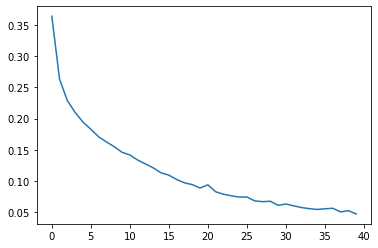

In [24]:
metrics_BCE['loss'].plot.line()

<AxesSubplot:>

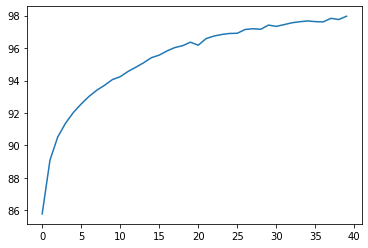

In [25]:
metrics_BCE['accuracy'].plot.line()

<AxesSubplot:>

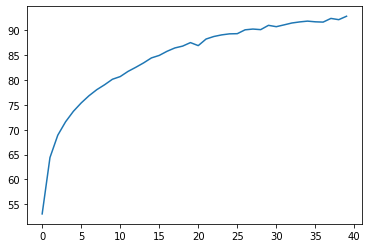

In [26]:
metrics_BCE['mIoU'].plot.line()

In [28]:
metrics_CE = pd.read_json('./metrics/metrics_ce_train.json')

In [29]:
metrics_dice = pd.read_json('./metrics/metrics_dice_train.json')

In [30]:
metrics_bce_dice = pd.read_json('./metrics/metrics_bce_dice_train.json')

### Comparaison Accuracy sur le nombre d'epochs

En suivant l'évolution de la courbe sur le nombre d'epochs on peut voir que la précision de la BCE et de la CE sont à peu près équivalentes. 

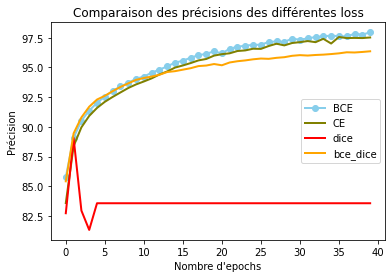

In [31]:
# multiple line plots
bce_acc = plt.plot( 'accuracy', data=metrics_BCE, marker='o',  color='skyblue', linewidth=2,label="BCE")
ce_acc = plt.plot( 'accuracy', data=metrics_CE, marker='', color='olive', linewidth=2,label="CE")
dice_acc = plt.plot( 'accuracy', data=metrics_dice, marker='', color='red', linewidth=2,label="dice")
bce_dice_acc = plt.plot( 'accuracy', data=metrics_bce_dice, marker='', color='orange', linewidth=2,label="bce_dice")

# show legend
plt.legend()
plt.xlabel("Nombre d'epochs")
plt.ylabel('Précision')
plt.title('Comparaison des précisions des différentes loss')

# show graph
plt.show()

### Comparaison Loss

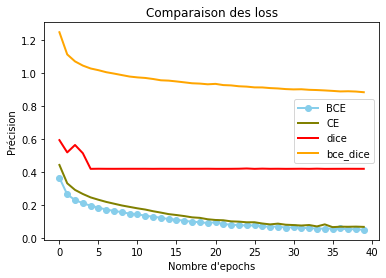

In [32]:
bce_loss = plt.plot( 'loss', data=metrics_BCE, marker='o',  color='skyblue', linewidth=2,label="BCE")
ce_loss = plt.plot( 'loss', data=metrics_CE, marker='', color='olive', linewidth=2,label="CE")
dice_loss = plt.plot( 'loss', data=metrics_dice, marker='', color='red', linewidth=2,label="dice")
bce_dice_loss = plt.plot( 'loss', data=metrics_bce_dice, marker='', color='orange', linewidth=2,label="bce_dice")

plt.legend()
plt.xlabel("Nombre d'epochs")
plt.ylabel('Précision')
plt.title('Comparaison des loss')

plt.show()

### Comparaison mIoU

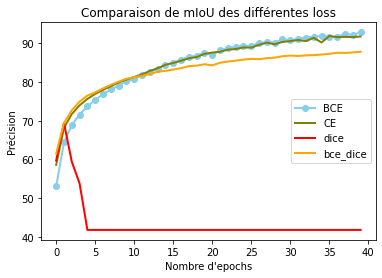

In [33]:
bce_mIoU = plt.plot('mIoU', data=metrics_BCE, marker='o',  color='skyblue', linewidth=2,label="BCE")
ce_mIoU = plt.plot('mIoU', data=metrics_CE, marker='', color='olive', linewidth=2,label="CE")
dice_mIoU = plt.plot('mIoU', data=metrics_dice, marker='', color='red', linewidth=2,label="dice")
bce_dice_mIoU = plt.plot('mIoU', data=metrics_bce_dice, marker='', color='orange', linewidth=2,label="bce_dice")

plt.legend()
plt.xlabel("Nombre d'epochs")
plt.ylabel('Précision')
plt.title('Comparaison de mIoU des différentes loss')

plt.show()

### Comparaison de la précision finale des loss 

In [37]:
metrics_dice_test = pd.read_json('./metrics/metrics_dice_test.json')
metrics_CE_test = pd.read_json('./metrics/metrics_ce_test.json')
metrics_BCE_test = pd.read_json('./metrics/metrics_bce_test.json')
metrics_BCE_dice_test = pd.read_json('./metrics/metrics_bce_dice_test.json')

In [38]:
BCE_final_acc = metrics_BCE_test['accuracy'].iloc[-1]
CE_final_acc = metrics_CE_test['accuracy'].iloc[-1]
dice_final_acc = metrics_dice_test['accuracy'].iloc[-1]
bce_dice_final_acc = metrics_BCE_dice_test['accuracy'].iloc[-1]

### Barplot des précisions par rapports aux différentes loss 

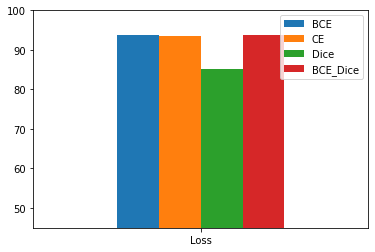

In [39]:
index = ['Loss']

df_acc = pd.DataFrame({'BCE':BCE_final_acc ,'CE':CE_final_acc,'Dice': dice_final_acc,'BCE_Dice':bce_dice_final_acc},index = index)
ax = df_acc.plot.bar(rot=0,ylim = (45,100))

### Test des différentes Loss sur des exemples 

In [40]:
# BCE 
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
output.backward()

print(output)

tensor(0.7677, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [41]:
# Crossentropy
loss = nn.CrossEntropyLoss(reduction="mean")
input = torch.randn(3, 2,requires_grad=True)
target = torch.empty(3,dtype=torch.long).random_(2)
output = loss(input, target)
output.backward()

print(output)

tensor(1.0690, grad_fn=<NllLossBackward>)


In [42]:
# Binary Dice Loss 
loss = BinaryDiceLoss
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
output.backward()

print(output)

tensor(-0.2869, grad_fn=<MeanBackward0>)
